In [1]:
import io
import os
import json
from google.protobuf.json_format import MessageToJson
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pprint

In [2]:
from google.cloud import vision
from google.cloud.vision import types

In [3]:
client = vision.ImageAnnotatorClient()

In [4]:
with io.open('./image_files/IMG_2053.jpg', 'rb') as image_file:
    content = image_file.read()

In [5]:
image = types.Image(content=content)

In [6]:
results = client.text_detection(image=image)
serialized = json.loads(MessageToJson(results))


In [23]:
# blocks = serialized['fullTextAnnotation']['pages'][0]['blocks']
pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(serialized['textAnnotations'])
blocks = serialized['textAnnotations']


text_boxes = []
for i in range(1, len(blocks)):
  block = blocks[i]
  text_box = {'text': block['description'], 'boundingPoly':[], 'midpoints':[], 'slope': None, 'intercept': None}
  for vertex in block['boundingPoly']['vertices']:
    curr_tuple = [vertex['x'], vertex['y']]
    text_box['boundingPoly'].append(curr_tuple)
  x = 0
  y = 1
  text_box['midpoints'].append(((text_box['boundingPoly'][0][x]+text_box['boundingPoly'][3][x])//2, 
                    (text_box['boundingPoly'][0][y]+text_box['boundingPoly'][3][y])//2 ))
  text_box['midpoints'].append(((text_box['boundingPoly'][1][x]+text_box['boundingPoly'][2][x])//2, 
                    (text_box['boundingPoly'][1][y]+text_box['boundingPoly'][2][y])//2 ))
  try:
      text_box['slope'] = (text_box['midpoints'][1][y]-text_box['midpoints'][0][y])/(text_box['midpoints'][1][x]-text_box['midpoints'][0][x])
      if text_box['slope'] > 50:
        text_box['slope'] = 50
        text_box['intercept'] = text_box['midpoints'][1][x]
      else:
          text_box['intercept'] = (-text_box['slope']*text_box['midpoints'][1][x])+text_box['midpoints'][1][y]
  except ZeroDivisionError:
      text_box['slope'] = 1000000
      text_box['intercept'] = text_box['midpoints'][1][x]
  
      
        
  
  
        

  text_boxes.append(text_box)

pp.pprint(text_boxes)

[   {   'boundingPoly': [   [2747, 1402],
                            [2747, 1439],
                            [2734, 1439],
                            [2734, 1402]],
        'intercept': 2740,
        'midpoints': [(2740, 1402), (2740, 1439)],
        'slope': 1000000,
        'text': '2'},
    {   'boundingPoly': [[1992, 627], [2080, 816], [1865, 917], [1776, 728]],
        'intercept': -3369.318181818182,
        'midpoints': [(1884, 677), (1972, 866)],
        'slope': 2.147727272727273,
        'text': 'OGERT'},
    {   'boundingPoly': [[2095, 852], [2248, 1180], [2032, 1281], [1879, 953]],
        'intercept': -3357.7124183006536,
        'midpoints': [(1987, 902), (2140, 1230)],
        'slope': 2.1437908496732025,
        'text': 'GALDINI'},
    {   'boundingPoly': [   [2283, 1255],
                            [2637, 2014],
                            [2421, 2115],
                            [2067, 1356]],
        'intercept': -3358.347457627119,
        'midpoints': [(2175,

In [35]:
books = []
added = {}
for i, first_text_box in enumerate(text_boxes):
    if not i in added:
        first_slope = first_text_box['slope']
        first_intercept = first_text_box['intercept']
        curr_book = first_text_box['text']
        for j, second_text_box in enumerate(text_boxes):
            num_ops += 1
            if not j in added and i is not j:
                second_slope = second_text_box['slope']
                second_intercept = second_text_box['intercept']
                next_book = second_text_box['text']
#                 print(curr_word,first_slope, next_word, second_slope)
                if (abs((first_slope*0.90)) <= abs(second_slope) <= abs((first_slope*1.10))) and (abs((first_intercept*0.90)) <= abs(second_intercept) <= abs((first_intercept*1.10))):
                    curr_book += ' ' + next_book
                    added[j]=True
        if len(curr_book) > 5:
            books.append(curr_book)
print(books)

['OGERT GALDINI PRE-SUASION', 'DANIEL KAHNEMAN FASTSLOW', 'THE ELEMENTS oF STYLE', '927 DAYS of SUMMER', 'TREE a life tery', "Chuck Klosterman But what If we 're wrong ?", 'TRIBE OF MENTORS TIMOTHY FERRISS']


In [22]:
abs((2.8*0.90))

2.52

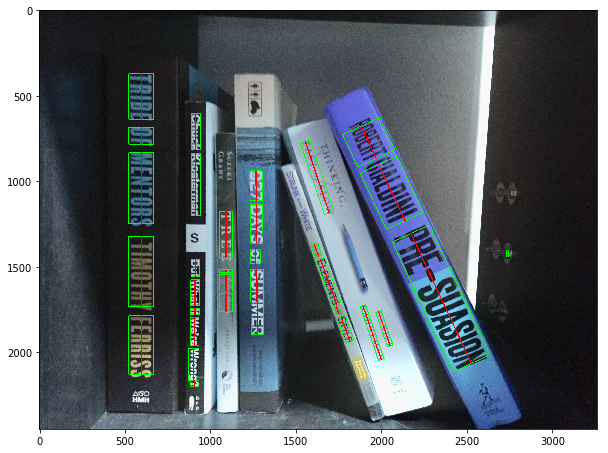

In [11]:
img = cv2.imread('./image_files/IMG_2053.jpg')
for text in text_boxes:
    bounds = text['boundingPoly']
    pts = np.array(bounds, np.int32)
    pts = pts.reshape((-1,1,2))
    img = cv2.polylines(img,[pts],True,(0,255,0),3)
    img = cv2.line(img,text['midpoints'][0],text['midpoints'][1],(255,0,0),5)
plt.rcParams['figure.figsize'] = (10,10)

plt.imshow(img)